In [2]:
%load_ext autoreload
%autoreload 2

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix  
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report 
from sklearn.externals.six import StringIO
from IPython.display import Image
from sklearn.tree import export_graphviz
import pydotplus

from src.utilities import functions_used as func

//anaconda3/envs/sklearn-env/lib/python3.7/site-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)


In [4]:
file_train = "~/ds/proj3/tanzania-water-wells/data/raw/training-set-values.csv" #x_train, training set values data
file_target_train = "~/ds/proj3/tanzania-water-wells/data/raw/training-labels.csv" #y_train, training set labels
file_test = "~/ds/proj3/tanzania-water-wells/data/raw/test-set.csv" #x_test, test set data

In [82]:
features = pd.read_csv(file_train)
targets = pd.read_csv(file_target_train)
X_test = pd.read_csv(file_test)

In [93]:
targets['status_group'] = targets['status_group'].map({'non functional':'needs repair','functional needs repair':'needs repair','functional':'functional'})

## Model 1: Decision Tree; Gini criterion

In [225]:
# This is our list of features, plus the target (required for our preprocessing step)

features_list = ['basin', 'region', 'scheme_management', 'scheme_name',
       'extraction_type', 'management', 'payment', 'water_quality', 'quantity',
       'source', 'waterpoint_type','gps_height', 'longitude', 'latitude', 
       'region_code', 'district_code', 'population', 'construction_year', 'status_group']   


In [226]:
# Initialize a One Hot Encoder object
ohe = OneHotEncoder(handle_unknown = 'ignore')

- Perform a train test split of the "training data" given in the problem. 
- Join the training data (X and y) together.


In [164]:
X_train, X_test, y_train, y_test = train_test_split(features, targets, random_state=42)

In [165]:
joined_train = X_train.join(y_train, lsuffix='_l', rsuffix='_r')

- Perform the pre-processing. Clean the numerical data. Perform One Hot Encoding.

In [166]:
joined_train_processed, y_train = func.model_preprocessing(joined_train, features_list, ohe, train = True)

Beginning numerical cleaning...
check: df shape =  (44550, 19)
---Dropping 0 longitudes...
check: df shape =  (43211, 19)
---Replace 0's with average constructor year...
check: df shape =  (43211, 19)
...returning a cleaned dataframe of numerical values.
Completed numerical cleaning.

Removing the target from the cleaned data frame...
---Length of target:  43211
---Shape of dataframe:  (43211, 18)
Reading the remaining columns as independent features

Begining "object" cleaning...
---Replacing NaN with "unknown" bin...
---Check: Number of rows with nulls: 0...

Begin one hot encoding data...
Finish one hot encoding data...

---Shape of ohe_df:  (43211, 2572)
...ending "object" cleaning.
Joining the cleaned numerical and object dataframes together.
Returning the main (independent features, X) and target (y) data frames...


- Train the decision tree with training data.

In [167]:
dtc = DecisionTreeClassifier(random_state=42, max_depth=5) 
dtc.fit(joined_train_processed, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=5, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')

- Repeat the pre-processing on the test data.
- Join the testing data (X and y) together.

In [168]:
joined_test = X_test.join(y_test, lsuffix='_l', rsuffix='_r')

- Preprocess the testing data.

In [169]:
joined_test_processed, y_test = func.model_preprocessing(joined_test, features_list, ohe, train=False)

Beginning numerical cleaning...
check: df shape =  (14850, 19)
---Dropping 0 longitudes...
check: df shape =  (14377, 19)
---Replace 0's with average constructor year...
check: df shape =  (14377, 19)
...returning a cleaned dataframe of numerical values.
Completed numerical cleaning.

Removing the target from the cleaned data frame...
---Length of target:  14377
---Shape of dataframe:  (14377, 18)
Reading the remaining columns as independent features

Begining "object" cleaning...
---Replacing NaN with "unknown" bin...
---Check: Number of rows with nulls: 0...

Begin one hot encoding data...
Finish one hot encoding data...

---Shape of ohe_df:  (14377, 2572)
...ending "object" cleaning.
Joining the cleaned numerical and object dataframes together.
Returning the main (independent features, X) and target (y) data frames...


- Make predictions with the test data.

In [170]:
predicts = dtc.predict(joined_test_processed)

- Check the score of the model.

In [171]:
dtc.score(joined_test_processed, y_test) #x_test, y_test from split

0.7203171732628504

In [172]:
func.calc_accuracy(y_test, predicts)

Confusion Matrix:  [[7529  333]
 [3688 2827]]
Accuracy :  72.03171732628503
Report :                precision    recall  f1-score   support

  functional       0.67      0.96      0.79      7862
needs repair       0.89      0.43      0.58      6515

    accuracy                           0.72     14377
   macro avg       0.78      0.70      0.69     14377
weighted avg       0.77      0.72      0.70     14377



Not bad for a first pass, but we can do better!

## Model #2 - Random Forest
We're going to do a small gridsearch for a Random Forest Classifier

In [227]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier


param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [10, 25, 50]
}
rfc = RandomForestClassifier(n_estimators=50, random_state=42, bootstrap=True, max_depth = 50)
gs = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=5)

In [174]:
gs.fit(joined_train_processed, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=50, n_jobs=None,
                                              oob_score=False, random_state=1,
                                    

In [175]:
gs.best_params_

{'criterion': 'gini', 'max_depth': 50}

In [176]:
gs.best_score_

0.8163661223277648

In [177]:
gs.best_estimator_

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=50, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)

In [195]:
rfc.fit(joined_train_processed,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=50, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [196]:
rfc_predicts = rfc.predict(joined_test_processed)

In [197]:
rfc.score(joined_test_processed, y_test)

0.8200598177644849

In [198]:
confusion_matrix(y_test, rfc_predicts)

array([[6780, 1082],
       [1505, 5010]])

In [207]:
func.calc_accuracy(y_test, rfc_predicts)

Confusion Matrix:  [[6780 1082]
 [1505 5010]]
Accuracy :  82.0059817764485
Report :                precision    recall  f1-score   support

  functional       0.82      0.86      0.84      7862
needs repair       0.82      0.77      0.79      6515

    accuracy                           0.82     14377
   macro avg       0.82      0.82      0.82     14377
weighted avg       0.82      0.82      0.82     14377



This performs really well!

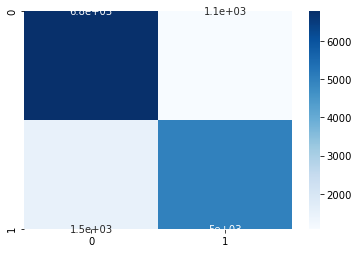

In [188]:
sns.heatmap(confusion_matrix(y_test, rfc_predicts),annot=True, cmap='Blues')

In [199]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import euclidean as euc
import numpy as np
import pandas as pd
from sklearn.datasets import make_classification
# from visualize import generate_moons_df, preprocess, plot_boundaries

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
np.random.seed(0)

# Model 3 KNN

With our one hot encoding, this model is incredibly resource intensive. It also did not perform better than the random forest, so for the sake of time we decided it not worth honing in on hyper parameter tuning for it

In [ ]:
scaler = StandardScaler()
scaler.fit(joined_train_processed)
X_train_scaled = scaler.transform(joined_train_processed)
X_test_scaled = scaler.transform(joined_test_processed)

In [201]:
knn = KNeighborsClassifier(n_neighbors=3)
# knn.fit(joined_train_processed, y_train)

knn.fit(X_train_scaled,y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')

In [202]:
sk_preds = knn.predict(X_test_scaled)

In [ ]:
knn.score(X_test_scaled,y_test)

In [204]:
func.calc_accuracy(y_test,sk_preds)

Confusion Matrix:  [[6456 1406]
 [1664 4851]]
Accuracy :  78.64644918967795
Report :                precision    recall  f1-score   support

  functional       0.80      0.82      0.81      7862
needs repair       0.78      0.74      0.76      6515

    accuracy                           0.79     14377
   macro avg       0.79      0.78      0.78     14377
weighted avg       0.79      0.79      0.79     14377



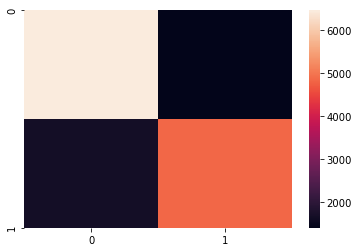

In [217]:
sns.heatmap(confusion_matrix(y_test, sk_preds),)

# Model 4 - Logistic Regression

In [228]:
logreg = LogisticRegression(solver='sag', max_iter=20, random_state=42)

logreg.fit(joined_train_processed, y_train)

confusion_matrix(y_test, logreg.predict(joined_test_processed))

//anaconda3/envs/sklearn-env/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


array([[4695, 3167],
       [3472, 3043]])

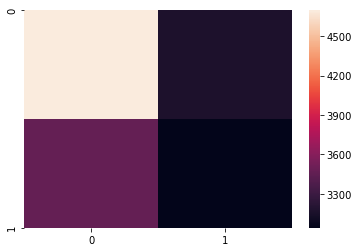

In [229]:
sns.heatmap(confusion_matrix(y_test, logreg.predict(joined_test_processed)),)

In [230]:
func.calc_accuracy(y_test, logreg.predict(joined_test_processed))

Confusion Matrix:  [[4695 3167]
 [3472 3043]]
Accuracy :  53.82207692842735
Report :                precision    recall  f1-score   support

  functional       0.57      0.60      0.59      7862
needs repair       0.49      0.47      0.48      6515

    accuracy                           0.54     14377
   macro avg       0.53      0.53      0.53     14377
weighted avg       0.54      0.54      0.54     14377



# Model 5 AdaBoost

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
abc = AdaBoostClassifier(random_state=42)
abc.fit(joined_train_processed, y_train)
predicts = abc.predict(joined_test_processed)

In [220]:
abc.score(joined_train_processed, y_train)

0.7531878456874407

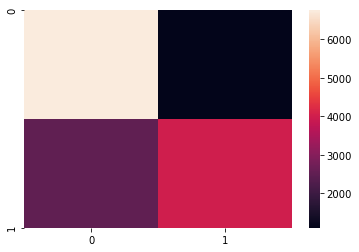

In [222]:
sns.heatmap(confusion_matrix(y_test, predicts))

In [223]:
func.calc_accuracy(y_test, predicts)

Confusion Matrix:  [[6752 1110]
 [2514 4001]]
Accuracy :  74.79307226820616
Report :                precision    recall  f1-score   support

  functional       0.73      0.86      0.79      7862
needs repair       0.78      0.61      0.69      6515

    accuracy                           0.75     14377
   macro avg       0.76      0.74      0.74     14377
weighted avg       0.75      0.75      0.74     14377

